# A - Cumulative subducted water

Produce grids of cumulative subducted from each contribution of:

- Sediment
- Serpentinite
- Crust
- Lithosphere

through time.


### Note: To save the outputs in this notebook once, the chosen hard drive requires at least 150 GB of free storage.

In [1]:
from multiprocessing import Pool, cpu_count
from joblib import Parallel, delayed
import joblib
import numpy as np
import pygplates
import os
os.environ["DISABLE_GPLATELY_DEV_WARNING"] = "true"
import gplately
import gplately.grids as grids
import gplately.tools as tools
import gplately.ptt as ptt
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io import shapereader as shpreader
import netCDF4
from scipy import ndimage
import pandas as pd
import glob, os
from slabdip import SlabDipper
import numpy.ma as ma
%matplotlib inline
# plt.style.use('ggplot')

#from pygplates_helper import *

# common variables
extent_globe = [-180, 180, -90, 90]
earth_radius = 6371.0e3
earth_surface_area = 4.0*np.pi*earth_radius**2
tessellation_threshold_radians = np.radians(0.01)

# output grid resolution - should be identical to input grid resolution!
spacingX, spacingY = 0.2, 0.2
resX, resY = int(360./0.2 + 1), int(180./0.2 + 1)
lon_grid = np.arange(extent_globe[0], extent_globe[1]+spacingX, spacingX)
lat_grid = np.arange(extent_globe[2], extent_globe[3]+spacingY, spacingY)
lonq, latq = np.meshgrid(lon_grid,lat_grid)

# reconstruction time steps and spacing
min_time = 0
max_time = 1800
timestep_size = 1

# time array
# reversed (start at max_time, end at min_time)
reconstruction_times = np.arange(max_time, min_time-timestep_size, -timestep_size)




# OUTPUT SAVING TOGGLES
save_output_netcdf = True # !! important
save_output_snapshots = False

# This is to save outputs from the parallelised "carbon_subducted_and_accreted" routine
save_outputs_to_csv = True


### Ensure all needed output paths are created

In [2]:
save_cumulative_subducted_water = True
save_smoothed_timestep_grid = True
save_smoothed_cumulative_grid = True

# Save the sum of crust + lithosphere + serpentinite
save_mantle_cumulative_subducted_water = True

In [13]:
parent_dir = "./Outputs/"

# Lithosphere
lithosphere_top_dir = parent_dir+"Reservoirs/Lithosphere/top/"
lithosphere_bottom_dir = parent_dir+ "Reservoirs/Lithosphere/bottom/"

# Crust
crust_bound_dir = parent_dir+"Reservoirs/Crust/bound/"
crust_pore_dir  = parent_dir+"Reservoirs/Crust/pore/"

# Sediments
sediments_bound_dir = parent_dir+"Reservoirs/Sediment/bound/"
sediments_pore_dir = parent_dir+"Reservoirs/Sediment/pore/"


# this relies on a consistent folder structure - don't meddle!

water_components = [lithosphere_bottom_dir, lithosphere_top_dir,
                    crust_bound_dir, crust_pore_dir,
                    sediments_bound_dir, sediments_pore_dir]
headers  = ['lithosphere_bottom', 'lithosphere_top',
            'crust_bound', 'crust_pore',
            'sediment_bound', 'sediment_pore',
            'mantle', 'crust', 'sediment']
quantities = ["min", "mean", "max"]

output_cdf_filename = "{}/{}/subducted_water_{}_{}.nc"

In [18]:
distance_km = 1000

# --------------- Everything below here can be kept as-is ----------------
# FOR CUMULATIVE SUBDUCTED WATER PER TIMESTEP
output_cumulative_subducted_water_grid_directory = parent_dir+"/cumulative_subducted_water/{}/{}/"
output_smooth_cumulative_subducted_water_grid_directory = parent_dir+"/smoothed_cumulative_subducted_water/{}km/{}/{}/"
output_smoothed_subducted_water_grid_directory = parent_dir+"/smoothed_subducted_water/{}km/{}/{}/"

# Define path to the cumulative SUBDUCTED WATER grid we will make in this cell
output_cumulative_subducted_water_filename = output_cumulative_subducted_water_grid_directory+"/cumulative_subducted_water_{}_{}.nc"
output_smooth_cumulative_subducted_water_filename = output_smooth_cumulative_subducted_water_grid_directory+"/cumulative_subducted_water_{}_{}.nc"
smoothed_subducted_water_grid_filename = output_smoothed_subducted_water_grid_directory+"/subducted_water_{}_{}.nc"

for storage in headers:
    for quantity in ['min', 'mean', 'max']:
        os.makedirs(output_cumulative_subducted_water_grid_directory.format(storage, quantity), exist_ok=True)
        os.makedirs(output_smooth_cumulative_subducted_water_grid_directory.format(distance_km, storage, quantity), exist_ok=True)
        os.makedirs(output_smoothed_subducted_water_grid_directory.format(distance_km, storage, quantity), exist_ok=True)
        

Define gplately's `PlateReconstruction` and `PlotTopologies` objects.

In [5]:
# Location of Cao2024 1.8Ga plate model.
model_dir = "../utils/Cao_etal_2024_1.8_Ga_mantle_ref_frame"
# Rotation files (relative to input directory).
rotation_features = [
    model_dir+'/optimisation/1800_1000_rotfile_20240725.rot',
    model_dir+'/optimisation/1000_0_rotfile_20240725.rot',
]

# Topology features (absolute file paths).
# Only include those GPML files that are used for topologies.
topology_features = [
    model_dir+'/1800-1000_plate_boundaries.gpml',
    model_dir+'/250-0_plate_boundaries.gpml',
    model_dir+'/410-250_plate_boundaries.gpml',
    model_dir+'/1000-410-Convergence.gpml',
    model_dir+'/1000-410-Divergence.gpml',
    model_dir+'/1000-410-plate-boundaries.gpml',
    model_dir+'/1000-410-Transforms.gpml',
    model_dir+'/TopologyBuildingBlocks.gpml',
]
# Continent polygon features (absolute file paths).
continent_features = [
    model_dir+'/shapes_continents.gpmlz',
]

# Pass filenames into gplately objects
model = gplately.PlateReconstruction(rotation_model=rotation_features, topology_features=topology_features)
gplot = gplately.PlotTopologies(model, time=1800, continents=continent_features)

In [6]:
cell_area = tools.lat_area_function(lat_grid, lat_grid+spacingY, lon_grid.size)
cell_area = np.tile(cell_area.reshape(-1,1), lon_grid.size)

## Make rasters of cumulative SUBDUCTED WATER

### Build the `cumulative_subducted_water` array
If `save_output_netcdf` was set to `True` in Notebook `02-Subducted-Carbon.ipynb`, masked arrays of total global SUBDUCTED WATER per timestep would have been saved to a netCDF4 grid. All grid nodes with no SUBDUCTED WATER are given NaN entries.

In the cells below, we loop through time to collect the carbon subducted for each carbon storage reservoir and quantity. At each time step, we append the current contribution to an array, `cumulative_subducted_water` for a given component and quantity. Every timestep we save the current cumulative SUBDUCTED WATER grid to a netcdf file.

To make this process faster, it is performed using parallelisation with `joblib`. The process is made more memory-friendly by partitioning the time array (and thus the parallel tasks) into groups of times. 

In [7]:
# Define carbon quantities
quantities = ["min", "mean", "max"]

# Define path to the SUBDUCTED WATER contributions per timestep
def get_subducted_water_grid_filename(c, quantity, reconstruction_time):
    subducted_water_grid_filename = water_components[c]+"{}/subducted_water_{}_{}.nc".format(
        quantity, headers[c].split('_')[0], reconstruction_time
    )
    return subducted_water_grid_filename


### Function to smooth SUBDUCTED WATER contribution grids with `scipy.ndimage`'s `fourier_gaussian()` filter
...which we access from an outsourced utility script `fft_gaussian_filter.py` in the `/utils/` directory.

In [8]:
if save_smoothed_timestep_grid:
    
    import sys
    sys.path.insert(0, '../utils/')

    import fft_gaussian_filter as fft_gaussian_filter_script

    def gaussian_smooth_grid(data, distance_km):
   
        """ Smooth grids using a Gaussian. 
        If input grid comes with a mask, all masked values are retained. 
        """
        mask = np.isnan(data)
        smoothed_grid = fft_gaussian_filter_script.fft_gaussian_filter(data, distance_km)
        smoothed_grid[mask] = np.nan
        return smoothed_grid

Select a Gaussian filter width (km) and produce a save directory for all cumulative grids with this smoothing filter width.

### Accumulate grids in parallel, save to netCDF in a single core 

In [9]:
def accumulate_subducted_water(c, component, reconstruction_time, distance_km=300):
    """Function to read water contribution plots for the given component and time, 
    smooth it, then return the smoothed piecewise grid. 
    """
    # Store cumulative SUBDUCTED WATER from the grids in a numpy array
    subducted_water_components = np.zeros((3, resY, resX))
    smoothed_subducted_water_components = np.zeros((3, resY, resX))

    for i, quantity in enumerate(quantities):

        # Read the masked SUBDUCTED WATER contribution array for the current time
        subducted_water_filename = get_subducted_water_grid_filename(c, quantity, reconstruction_time)
        current_time_grid = grids.read_netcdf_grid(subducted_water_filename)

        # Get the data array, and fill all NaNs with 0s.
        current_time_grid = np.nan_to_num(current_time_grid.data)
        current_time_grid_filled = grids.fill_raster(current_time_grid)
        subducted_water_components[i] = current_time_grid_filled

        # If the user wants the smoothed piecewise grids to be returned,
        if save_smoothed_timestep_grid:

            # Define the filename for saving the smoothed grids
            smoothed_filename = smoothed_subducted_water_grid_filename.format(
                distance_km, component, quantity, component.lower(), reconstruction_time
            )
            # Smooth the grids
            smoothed_current_time_grid = gaussian_smooth_grid(
                current_time_grid_filled,
                distance_km=distance_km
            )
            # Read in the smoothed grid, fill the raster, and return
            smoothed_current_time_grid_filled = grids.fill_raster(smoothed_current_time_grid)
            smoothed_subducted_water_components[i] += smoothed_current_time_grid_filled
            
            # Create a mask for the interpolated grid - all values with 0s need to have an equivalent
            # mask value of NaN. 
            smoothed_current_time_grid_filled_masked = ma.masked_array(smoothed_current_time_grid_filled)
            smoothed_current_time_grid_filled_masked = ma.masked_values(smoothed_current_time_grid_filled_masked, 0.0)
            smoothed_current_time_grid_filled_masked.fill_value = np.nan
            
            current_subducted_water_smoothed = np.ma.array(
                    smoothed_subducted_water_components[i],
                    mask = smoothed_current_time_grid_filled_masked.mask,
                    fill_value=np.nan
                )
            
            grids.write_netcdf_grid(
                smoothed_filename,
                current_subducted_water_smoothed
            )

    if save_smoothed_timestep_grid:
        return subducted_water_components, reconstruction_time, smoothed_current_time_grid_filled, smoothed_filename
    else:
        return subducted_water_components, reconstruction_time

        
def accumulate_smoothed_mantle_grids(reconstruction_time, distance_km=300):
    """A function to make mantle grids, ie add lithosphere, crust and serpentinite over 1 Myr
    """
    # Store cumulative SUBDUCTED WATER from the grids in a numpy array
    smoothed_subducted_water_components = np.zeros((3, resY, resX))

    for i, quantity in enumerate(quantities):
        # Add Lithosphere bottom, Lithosphere top, Crust bound, Crust pore, Sediment bound, Sediment pore
        for c, component in enumerate(headers[:-2]):

            subducted_water_filename = smoothed_subducted_water_grid_filename.format(
                distance_km, component, quantity, component.lower(), reconstruction_time
            )

            current_time_grid = grids.read_netcdf_grid(subducted_water_filename)
            # Get the data array, and fill all NaNs with 0s.
            current_time_grid = np.nan_to_num(current_time_grid.data)
            current_time_grid_filled = grids.fill_raster(current_time_grid)

            # For the current time, we have a 3 by resY by resX grid. Each dimension in
            # axis 0 is the sum of all crust, serpentinite and lithosphere in the 
            # min, mean and max (respectively)
            smoothed_subducted_water_components[i] += current_time_grid_filled

    return smoothed_subducted_water_components


def accumulate_reservoir_grids(reconstruction_time, component, distance_km=300):
    """A general function to get the smoothed piecewise carbon grid at the current
    time then turn it into a raster
    """
    # Store cumulative SUBDUCTED WATER from the grids in a numpy array
    smoothed_subducted_water_components = np.zeros((3, resY, resX))

    for i, quantity in enumerate(quantities):

        subducted_water_filename = smoothed_subducted_water_grid_filename.format(
            distance_km, component, quantity, component.lower(), reconstruction_time
        )

        current_time_grid = grids.read_netcdf_grid(subducted_water_filename)
        # Get the data array, and fill all NaNs with 0s.
        current_time_grid = np.nan_to_num(current_time_grid.data)
        current_time_grid_filled = grids.fill_raster(current_time_grid)

        # For the current time, we have a 3 by resY by resX grid. Each dimension in
        # axis 0 is the current reservoir SUBDUCTED WATER grid in min, mean and max (respectively)
        smoothed_subducted_water_components[i] += current_time_grid_filled

    return smoothed_subducted_water_components

## Accumulate grids in parallel...

This cell can get memory-intensive. We can relieve memory pressure by setting `time_splitter_integer` to a smaller value. It can be 0, or negative. The smaller the value, the smaller the chunks of timesteps used for accumulation.

In [10]:
time_splitter_integer = -5

In [11]:
with Parallel(n_jobs=-3, verbose=1) as parallel:
    cumulative_subducted_water = np.zeros((len(headers[:-2]), 3, resY, resX))
    smoothed_cumulative_subducted_water = np.zeros((len(headers[:-2]), 3, resY, resX))
    total_smoothed_cumulative_mantle = np.zeros((3, resY, resX))
    
    # Split the time array into groups of timesteps
    split_times = np.array_split(reconstruction_times, cpu_count() - time_splitter_integer)
    
    # Start counting current time from min_time
    curr_time = min_time
    
    # Loop through each time array. get a group of SUBDUCTED WATER contributions
    for times in split_times:
        for c, component in enumerate(headers[:-2]):
            
            print("Accumulating {} grids from {} to {}Ma...".format(component, times[0], times[-1]))

            # Read the timewise contributions from this batch of times and smooth them. 
            results = parallel(delayed(accumulate_subducted_water)(
                c,
                component, 
                time,
                distance_km=distance_km
            ) 
               for time in times
            )
            
            results = np.array(results, dtype=object)
            # Remember the times that were accumulated in the parallelised batch as this can be mixed/non-ordered in parallel
            carbon_subducted = results[:,0]
            curr_times = results[:,1]
            
            if save_smoothed_timestep_grid:
                print("Smoothed {} grids from {} to {}Ma, saving grids now...".format(component, times[0], times[-1]))
                smoothed_carbon_subducted = results[:,2]

            # For each time index and SUBDUCTED WATER piecewise grid in the current result array,
            for t, subducted_water_components in enumerate(carbon_subducted):
                
                # We have one array per timestep with 1st dimension being component then 2nd dimension being min, mean and max. 
                # Accumulate the current component up to the most recent time.
                if save_cumulative_subducted_water:
                    cumulative_subducted_water[c] += subducted_water_components 
                
                # Repeat for the smoothed SUBDUCTED WATER piecewise grids if saving smoothed grids. 
                if save_smoothed_cumulative_grid:
                    smoothed_cumulative_subducted_water[c] += smoothed_carbon_subducted[t]
                    
                # Loop through each quantity
                for q, quantity in enumerate(quantities):
                    
                    # Save the raw cumulative SUBDUCTED WATER grid. 
                    if save_cumulative_subducted_water:
                        
                        # Make the mask
                        cumulative_subducted_water_curr = ma.masked_array(cumulative_subducted_water[c,q])
                        cumulative_subducted_water_curr = ma.masked_values(cumulative_subducted_water_curr, 0.0)
                        cumulative_subducted_water_curr.fill_value = np.nan

                        current_cumulative_subducted_water = np.ma.array(
                                cumulative_subducted_water[c,q],
                                mask = cumulative_subducted_water_curr.mask,
                                fill_value=np.nan
                            )
                        
                        gplately.grids.write_netcdf_grid(
                            output_cumulative_subducted_water_filename.format( 
                                
                                component, 
                                quantity, 
                                component.lower(), 
                                curr_times[t]
                            ), 
                            current_cumulative_subducted_water
                        )


        # Need a separate section for mantle as we are adding three components together. 
        if save_mantle_cumulative_subducted_water:

            print("Summing mantle grids (lithosphere + crust + sediment) from {} to {}Ma...".format(times[0], times[-1]))
            mantle_results = parallel(delayed(accumulate_smoothed_mantle_grids)(time, distance_km) for time in times)
            mantle_results_arr = np.array(mantle_results, dtype=object)
            mantle_cumulative_results = mantle_results_arr[:,0]
            
            print("Saving mantle grids (lithosphere + crust + sediment) from {} to {}Ma...".format(times[0], times[-1]))
            
            for t, curr_time_mantle_carbon in enumerate(mantle_cumulative_results):
                
                curr_time_mantle_carbon = curr_time_mantle_carbon.astype(dtype=float)
                total_smoothed_cumulative_mantle += curr_time_mantle_carbon
                
                for q, quantity in enumerate(quantities):
                    
                    current_mantle = total_smoothed_cumulative_mantle[q,:]
                    current_mantle_filled = grids.fill_raster(current_mantle)

                    # Save the smoothed cumulative SUBDUCTED WATER grid. 
                    gplately.grids.write_netcdf_grid(
                        output_smooth_cumulative_subducted_water_filename.format(
                            distance_km,
                            "Mantle", 
                            quantity, 
                            "Mantle".lower(), 
                            times[t]
                        ), 
                        current_mantle_filled
                    )

                                

Accumulating lithosphere_bottom grids from 1800 to 1680Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:   14.0s
[Parallel(n_jobs=-3)]: Done 121 out of 121 | elapsed:   41.9s finished


Smoothed lithosphere_bottom grids from 1800 to 1680Ma, saving grids now...
Accumulating lithosphere_top grids from 1800 to 1680Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:   16.9s
[Parallel(n_jobs=-3)]: Done 121 out of 121 | elapsed:   47.3s finished


Smoothed lithosphere_top grids from 1800 to 1680Ma, saving grids now...
Accumulating crust_bound grids from 1800 to 1680Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-3)]: Done 121 out of 121 | elapsed:   44.1s finished


Smoothed crust_bound grids from 1800 to 1680Ma, saving grids now...
Accumulating crust_pore grids from 1800 to 1680Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-3)]: Done 121 out of 121 | elapsed:   46.1s finished


Smoothed crust_pore grids from 1800 to 1680Ma, saving grids now...
Accumulating sediment_bound grids from 1800 to 1680Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:   12.5s
[Parallel(n_jobs=-3)]: Done 121 out of 121 | elapsed:   41.1s finished


Smoothed sediment_bound grids from 1800 to 1680Ma, saving grids now...
Accumulating sediment_pore grids from 1800 to 1680Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:   13.7s
[Parallel(n_jobs=-3)]: Done 121 out of 121 | elapsed:   43.3s finished


Smoothed sediment_pore grids from 1800 to 1680Ma, saving grids now...
Summing mantle grids (lithosphere + crust + sediment) from 1800 to 1680Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:   48.9s
[Parallel(n_jobs=-3)]: Done 121 out of 121 | elapsed:  2.2min finished


Saving mantle grids (lithosphere + crust + sediment) from 1800 to 1680Ma...
Accumulating lithosphere_bottom grids from 1679 to 1560Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:   13.2s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:   39.8s finished


Smoothed lithosphere_bottom grids from 1679 to 1560Ma, saving grids now...
Accumulating lithosphere_top grids from 1679 to 1560Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:   47.6s finished


Smoothed lithosphere_top grids from 1679 to 1560Ma, saving grids now...
Accumulating crust_bound grids from 1679 to 1560Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:   15.2s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:   55.4s finished


Smoothed crust_bound grids from 1679 to 1560Ma, saving grids now...
Accumulating crust_pore grids from 1679 to 1560Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:   47.8s finished


Smoothed crust_pore grids from 1679 to 1560Ma, saving grids now...
Accumulating sediment_bound grids from 1679 to 1560Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:   14.8s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:   46.5s finished


Smoothed sediment_bound grids from 1679 to 1560Ma, saving grids now...
Accumulating sediment_pore grids from 1679 to 1560Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:   47.0s finished


Smoothed sediment_pore grids from 1679 to 1560Ma, saving grids now...
Summing mantle grids (lithosphere + crust + sediment) from 1679 to 1560Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:   40.1s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:  1.9min finished


Saving mantle grids (lithosphere + crust + sediment) from 1679 to 1560Ma...
Accumulating lithosphere_bottom grids from 1559 to 1440Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:   14.0s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:   45.2s finished


Smoothed lithosphere_bottom grids from 1559 to 1440Ma, saving grids now...
Accumulating lithosphere_top grids from 1559 to 1440Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:   14.8s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:   46.4s finished


Smoothed lithosphere_top grids from 1559 to 1440Ma, saving grids now...
Accumulating crust_bound grids from 1559 to 1440Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:   47.5s finished


Smoothed crust_bound grids from 1559 to 1440Ma, saving grids now...
Accumulating crust_pore grids from 1559 to 1440Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:   54.1s finished


Smoothed crust_pore grids from 1559 to 1440Ma, saving grids now...
Accumulating sediment_bound grids from 1559 to 1440Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:   14.8s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:   51.3s finished


Smoothed sediment_bound grids from 1559 to 1440Ma, saving grids now...
Accumulating sediment_pore grids from 1559 to 1440Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:   14.8s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:   47.2s finished


Smoothed sediment_pore grids from 1559 to 1440Ma, saving grids now...
Summing mantle grids (lithosphere + crust + sediment) from 1559 to 1440Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:   30.6s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:  1.6min finished


Saving mantle grids (lithosphere + crust + sediment) from 1559 to 1440Ma...
Accumulating lithosphere_bottom grids from 1439 to 1320Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:   46.3s finished


Smoothed lithosphere_bottom grids from 1439 to 1320Ma, saving grids now...
Accumulating lithosphere_top grids from 1439 to 1320Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:   15.2s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:   48.6s finished


Smoothed lithosphere_top grids from 1439 to 1320Ma, saving grids now...
Accumulating crust_bound grids from 1439 to 1320Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:   48.1s finished


Smoothed crust_bound grids from 1439 to 1320Ma, saving grids now...
Accumulating crust_pore grids from 1439 to 1320Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:   15.4s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:   48.3s finished


Smoothed crust_pore grids from 1439 to 1320Ma, saving grids now...
Accumulating sediment_bound grids from 1439 to 1320Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:   48.6s finished


Smoothed sediment_bound grids from 1439 to 1320Ma, saving grids now...
Accumulating sediment_pore grids from 1439 to 1320Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:   48.0s finished


Smoothed sediment_pore grids from 1439 to 1320Ma, saving grids now...
Summing mantle grids (lithosphere + crust + sediment) from 1439 to 1320Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:   28.9s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:  1.3min finished


Saving mantle grids (lithosphere + crust + sediment) from 1439 to 1320Ma...
Accumulating lithosphere_bottom grids from 1319 to 1200Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:   15.2s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:   53.7s finished


Smoothed lithosphere_bottom grids from 1319 to 1200Ma, saving grids now...
Accumulating lithosphere_top grids from 1319 to 1200Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:   49.3s finished


Smoothed lithosphere_top grids from 1319 to 1200Ma, saving grids now...
Accumulating crust_bound grids from 1319 to 1200Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:   15.5s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:   49.0s finished


Smoothed crust_bound grids from 1319 to 1200Ma, saving grids now...
Accumulating crust_pore grids from 1319 to 1200Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:   15.1s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:   50.8s finished


Smoothed crust_pore grids from 1319 to 1200Ma, saving grids now...
Accumulating sediment_bound grids from 1319 to 1200Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:   14.5s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:   46.6s finished


Smoothed sediment_bound grids from 1319 to 1200Ma, saving grids now...
Accumulating sediment_pore grids from 1319 to 1200Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:   48.7s finished


Smoothed sediment_pore grids from 1319 to 1200Ma, saving grids now...
Summing mantle grids (lithosphere + crust + sediment) from 1319 to 1200Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:   25.1s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:  1.4min finished


Saving mantle grids (lithosphere + crust + sediment) from 1319 to 1200Ma...
Accumulating lithosphere_bottom grids from 1199 to 1080Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:   15.3s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:   47.9s finished


Smoothed lithosphere_bottom grids from 1199 to 1080Ma, saving grids now...
Accumulating lithosphere_top grids from 1199 to 1080Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:   17.1s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:   49.7s finished


Smoothed lithosphere_top grids from 1199 to 1080Ma, saving grids now...
Accumulating crust_bound grids from 1199 to 1080Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:   59.4s finished


Smoothed crust_bound grids from 1199 to 1080Ma, saving grids now...
Accumulating crust_pore grids from 1199 to 1080Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:   14.6s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:   47.8s finished


Smoothed crust_pore grids from 1199 to 1080Ma, saving grids now...
Accumulating sediment_bound grids from 1199 to 1080Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:   47.9s finished


Smoothed sediment_bound grids from 1199 to 1080Ma, saving grids now...
Accumulating sediment_pore grids from 1199 to 1080Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:   16.8s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:   49.5s finished


Smoothed sediment_pore grids from 1199 to 1080Ma, saving grids now...
Summing mantle grids (lithosphere + crust + sediment) from 1199 to 1080Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:   21.6s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:  1.2min finished


Saving mantle grids (lithosphere + crust + sediment) from 1199 to 1080Ma...
Accumulating lithosphere_bottom grids from 1079 to 960Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:   46.9s finished


Smoothed lithosphere_bottom grids from 1079 to 960Ma, saving grids now...
Accumulating lithosphere_top grids from 1079 to 960Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:   16.9s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:   49.2s finished


Smoothed lithosphere_top grids from 1079 to 960Ma, saving grids now...
Accumulating crust_bound grids from 1079 to 960Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:   47.3s finished


Smoothed crust_bound grids from 1079 to 960Ma, saving grids now...
Accumulating crust_pore grids from 1079 to 960Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:   15.3s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:   48.0s finished


Smoothed crust_pore grids from 1079 to 960Ma, saving grids now...
Accumulating sediment_bound grids from 1079 to 960Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:   47.8s finished


Smoothed sediment_bound grids from 1079 to 960Ma, saving grids now...
Accumulating sediment_pore grids from 1079 to 960Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:   15.2s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:   47.6s finished


Smoothed sediment_pore grids from 1079 to 960Ma, saving grids now...
Summing mantle grids (lithosphere + crust + sediment) from 1079 to 960Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:   34.3s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:  1.5min finished


Saving mantle grids (lithosphere + crust + sediment) from 1079 to 960Ma...
Accumulating lithosphere_bottom grids from 959 to 840Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:   50.0s finished


Smoothed lithosphere_bottom grids from 959 to 840Ma, saving grids now...
Accumulating lithosphere_top grids from 959 to 840Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:   21.1s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:   53.2s finished


Smoothed lithosphere_top grids from 959 to 840Ma, saving grids now...
Accumulating crust_bound grids from 959 to 840Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:   14.9s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:   47.8s finished


Smoothed crust_bound grids from 959 to 840Ma, saving grids now...
Accumulating crust_pore grids from 959 to 840Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:   14.8s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:   47.4s finished


Smoothed crust_pore grids from 959 to 840Ma, saving grids now...
Accumulating sediment_bound grids from 959 to 840Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:   14.6s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:   48.3s finished


Smoothed sediment_bound grids from 959 to 840Ma, saving grids now...
Accumulating sediment_pore grids from 959 to 840Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:   47.5s finished


Smoothed sediment_pore grids from 959 to 840Ma, saving grids now...
Summing mantle grids (lithosphere + crust + sediment) from 959 to 840Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:   28.6s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:  1.8min finished


Saving mantle grids (lithosphere + crust + sediment) from 959 to 840Ma...
Accumulating lithosphere_bottom grids from 839 to 720Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:   54.3s finished


Smoothed lithosphere_bottom grids from 839 to 720Ma, saving grids now...
Accumulating lithosphere_top grids from 839 to 720Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:   16.3s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:   48.4s finished


Smoothed lithosphere_top grids from 839 to 720Ma, saving grids now...
Accumulating crust_bound grids from 839 to 720Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:   16.8s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:   48.8s finished


Smoothed crust_bound grids from 839 to 720Ma, saving grids now...
Accumulating crust_pore grids from 839 to 720Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:   16.5s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:   48.7s finished


Smoothed crust_pore grids from 839 to 720Ma, saving grids now...
Accumulating sediment_bound grids from 839 to 720Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:   47.6s finished


Smoothed sediment_bound grids from 839 to 720Ma, saving grids now...
Accumulating sediment_pore grids from 839 to 720Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:   15.3s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:   48.7s finished


Smoothed sediment_pore grids from 839 to 720Ma, saving grids now...
Summing mantle grids (lithosphere + crust + sediment) from 839 to 720Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:   38.8s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:  1.7min finished


Saving mantle grids (lithosphere + crust + sediment) from 839 to 720Ma...
Accumulating lithosphere_bottom grids from 719 to 600Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:   15.3s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:   46.2s finished


Smoothed lithosphere_bottom grids from 719 to 600Ma, saving grids now...
Accumulating lithosphere_top grids from 719 to 600Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:   16.4s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:   49.1s finished


Smoothed lithosphere_top grids from 719 to 600Ma, saving grids now...
Accumulating crust_bound grids from 719 to 600Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:   14.8s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:   54.7s finished


Smoothed crust_bound grids from 719 to 600Ma, saving grids now...
Accumulating crust_pore grids from 719 to 600Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:   14.9s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:   47.2s finished


Smoothed crust_pore grids from 719 to 600Ma, saving grids now...
Accumulating sediment_bound grids from 719 to 600Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:   46.4s finished


Smoothed sediment_bound grids from 719 to 600Ma, saving grids now...
Accumulating sediment_pore grids from 719 to 600Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:   49.4s finished


Smoothed sediment_pore grids from 719 to 600Ma, saving grids now...
Summing mantle grids (lithosphere + crust + sediment) from 719 to 600Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:   22.3s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:  1.2min finished


Saving mantle grids (lithosphere + crust + sediment) from 719 to 600Ma...
Accumulating lithosphere_bottom grids from 599 to 480Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:   17.3s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:   50.0s finished


Smoothed lithosphere_bottom grids from 599 to 480Ma, saving grids now...
Accumulating lithosphere_top grids from 599 to 480Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:   14.5s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:   47.2s finished


Smoothed lithosphere_top grids from 599 to 480Ma, saving grids now...
Accumulating crust_bound grids from 599 to 480Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:   16.4s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:   48.2s finished


Smoothed crust_bound grids from 599 to 480Ma, saving grids now...
Accumulating crust_pore grids from 599 to 480Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:   57.7s finished


Smoothed crust_pore grids from 599 to 480Ma, saving grids now...
Accumulating sediment_bound grids from 599 to 480Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:   14.6s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:   45.6s finished


Smoothed sediment_bound grids from 599 to 480Ma, saving grids now...
Accumulating sediment_pore grids from 599 to 480Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:   46.3s finished


Smoothed sediment_pore grids from 599 to 480Ma, saving grids now...
Summing mantle grids (lithosphere + crust + sediment) from 599 to 480Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:   34.5s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:  1.9min finished


Saving mantle grids (lithosphere + crust + sediment) from 599 to 480Ma...
Accumulating lithosphere_bottom grids from 479 to 360Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:   15.3s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:   45.8s finished


Smoothed lithosphere_bottom grids from 479 to 360Ma, saving grids now...
Accumulating lithosphere_top grids from 479 to 360Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:   18.0s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:   49.6s finished


Smoothed lithosphere_top grids from 479 to 360Ma, saving grids now...
Accumulating crust_bound grids from 479 to 360Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:   50.8s finished


Smoothed crust_bound grids from 479 to 360Ma, saving grids now...
Accumulating crust_pore grids from 479 to 360Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:   17.2s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:   48.2s finished


Smoothed crust_pore grids from 479 to 360Ma, saving grids now...
Accumulating sediment_bound grids from 479 to 360Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:   46.6s finished


Smoothed sediment_bound grids from 479 to 360Ma, saving grids now...
Accumulating sediment_pore grids from 479 to 360Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:   16.5s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:   48.0s finished


Smoothed sediment_pore grids from 479 to 360Ma, saving grids now...
Summing mantle grids (lithosphere + crust + sediment) from 479 to 360Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:   42.4s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:  2.0min finished


Saving mantle grids (lithosphere + crust + sediment) from 479 to 360Ma...
Accumulating lithosphere_bottom grids from 359 to 240Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:   54.9s finished


Smoothed lithosphere_bottom grids from 359 to 240Ma, saving grids now...
Accumulating lithosphere_top grids from 359 to 240Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:   47.8s finished


Smoothed lithosphere_top grids from 359 to 240Ma, saving grids now...
Accumulating crust_bound grids from 359 to 240Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:   47.1s finished


Smoothed crust_bound grids from 359 to 240Ma, saving grids now...
Accumulating crust_pore grids from 359 to 240Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:   17.8s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:   51.8s finished


Smoothed crust_pore grids from 359 to 240Ma, saving grids now...
Accumulating sediment_bound grids from 359 to 240Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:   46.9s finished


Smoothed sediment_bound grids from 359 to 240Ma, saving grids now...
Accumulating sediment_pore grids from 359 to 240Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:   15.5s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:   46.2s finished


Smoothed sediment_pore grids from 359 to 240Ma, saving grids now...
Summing mantle grids (lithosphere + crust + sediment) from 359 to 240Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:   39.0s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:  2.1min finished


Saving mantle grids (lithosphere + crust + sediment) from 359 to 240Ma...
Accumulating lithosphere_bottom grids from 239 to 120Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:   14.8s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:   56.9s finished


Smoothed lithosphere_bottom grids from 239 to 120Ma, saving grids now...
Accumulating lithosphere_top grids from 239 to 120Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:   15.5s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:   50.3s finished


Smoothed lithosphere_top grids from 239 to 120Ma, saving grids now...
Accumulating crust_bound grids from 239 to 120Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:   15.5s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:   59.9s finished


Smoothed crust_bound grids from 239 to 120Ma, saving grids now...
Accumulating crust_pore grids from 239 to 120Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:   48.4s finished


Smoothed crust_pore grids from 239 to 120Ma, saving grids now...
Accumulating sediment_bound grids from 239 to 120Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:   14.9s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:   48.1s finished


Smoothed sediment_bound grids from 239 to 120Ma, saving grids now...
Accumulating sediment_pore grids from 239 to 120Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:   14.9s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:   48.1s finished


Smoothed sediment_pore grids from 239 to 120Ma, saving grids now...
Summing mantle grids (lithosphere + crust + sediment) from 239 to 120Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:   38.5s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:  2.1min finished


Saving mantle grids (lithosphere + crust + sediment) from 239 to 120Ma...
Accumulating lithosphere_bottom grids from 119 to 0Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:   49.6s finished


Smoothed lithosphere_bottom grids from 119 to 0Ma, saving grids now...
Accumulating lithosphere_top grids from 119 to 0Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:   15.5s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:   48.5s finished


Smoothed lithosphere_top grids from 119 to 0Ma, saving grids now...
Accumulating crust_bound grids from 119 to 0Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:   47.7s finished


Smoothed crust_bound grids from 119 to 0Ma, saving grids now...
Accumulating crust_pore grids from 119 to 0Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:   56.1s finished


Smoothed crust_pore grids from 119 to 0Ma, saving grids now...
Accumulating sediment_bound grids from 119 to 0Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:   45.1s finished


Smoothed sediment_bound grids from 119 to 0Ma, saving grids now...
Accumulating sediment_pore grids from 119 to 0Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:   47.4s finished


Smoothed sediment_pore grids from 119 to 0Ma, saving grids now...
Summing mantle grids (lithosphere + crust + sediment) from 119 to 0Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:   32.7s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:  1.6min finished


Saving mantle grids (lithosphere + crust + sediment) from 119 to 0Ma...


As an aside, also accumulate crustal carbon - individual contributions would have already been smoothed. 

In [12]:
crust_components = ["crust_bound", "crust_pore"]

with Parallel(n_jobs=-3, verbose=1) as parallel:
    
    total_smoothed_cumulative_crust = np.zeros((3, resY, resX))

    # Split the time array into groups of timesteps
    split_times = np.array_split(reconstruction_times, cpu_count() - time_splitter_integer)
    
    # Start counting current time from min_time
    curr_time = min_time
    
    # Loop through each time array. get a group of SUBDUCTED WATER contributions
    for times in split_times:

        for component in crust_components:
            print("Accumulating smoothed crust grids from {} to {}Ma...".format(times[0], times[-1]))
    
            crust_results = parallel(delayed(accumulate_reservoir_grids)(time, component, distance_km) for time in times)
            crust_results_arr = np.array(crust_results, dtype=object)
            crust_cumulative_results = crust_results_arr[:,0]
    
            print("Done! Saving cumulative smoothed crust grids from {} to {}Ma...".format(times[0], times[-1]))
    
            for t, curr_time_crust_carbon in enumerate(crust_cumulative_results):
    
                curr_time_crust_carbon = curr_time_crust_carbon.astype(dtype=float)
                total_smoothed_cumulative_crust += curr_time_crust_carbon
    
                for q, quantity in enumerate(quantities):
    
                    current_crust = total_smoothed_cumulative_sediment[q,:]
                    current_crust_filled = grids.fill_raster(current_crust)
    
                    # Save the smoothed cumulative SUBDUCTED WATER grid. 
                    gplately.grids.write_netcdf_grid(
                        output_smooth_cumulative_subducted_water_filename.format(
                            distance_km,
                            "Crust", 
                            quantity, 
                            "Crust".lower(), 
                            times[t]
                        ), 
                        current_crust_filled
                    )


Accumulating smoothed crust grids from 1800 to 1680Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-3)]: Done 121 out of 121 | elapsed:   24.5s finished


Done! Saving cumulative smoothed crust grids from 1800 to 1680Ma...
Accumulating smoothed crust grids from 1800 to 1680Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-3)]: Done 121 out of 121 | elapsed:   21.1s finished


Done! Saving cumulative smoothed crust grids from 1800 to 1680Ma...
Accumulating smoothed crust grids from 1679 to 1560Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:   20.7s finished


Done! Saving cumulative smoothed crust grids from 1679 to 1560Ma...
Accumulating smoothed crust grids from 1679 to 1560Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:   16.7s finished


Done! Saving cumulative smoothed crust grids from 1679 to 1560Ma...
Accumulating smoothed crust grids from 1559 to 1440Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:   16.0s finished


Done! Saving cumulative smoothed crust grids from 1559 to 1440Ma...
Accumulating smoothed crust grids from 1559 to 1440Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:   17.8s finished


Done! Saving cumulative smoothed crust grids from 1559 to 1440Ma...
Accumulating smoothed crust grids from 1439 to 1320Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:   16.1s finished


Done! Saving cumulative smoothed crust grids from 1439 to 1320Ma...
Accumulating smoothed crust grids from 1439 to 1320Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:   15.0s finished


Done! Saving cumulative smoothed crust grids from 1439 to 1320Ma...
Accumulating smoothed crust grids from 1319 to 1200Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:   14.9s finished


Done! Saving cumulative smoothed crust grids from 1319 to 1200Ma...
Accumulating smoothed crust grids from 1319 to 1200Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:   14.8s finished


Done! Saving cumulative smoothed crust grids from 1319 to 1200Ma...
Accumulating smoothed crust grids from 1199 to 1080Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:   12.7s finished


Done! Saving cumulative smoothed crust grids from 1199 to 1080Ma...
Accumulating smoothed crust grids from 1199 to 1080Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:   12.6s finished


Done! Saving cumulative smoothed crust grids from 1199 to 1080Ma...
Accumulating smoothed crust grids from 1079 to 960Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:   16.0s finished


Done! Saving cumulative smoothed crust grids from 1079 to 960Ma...
Accumulating smoothed crust grids from 1079 to 960Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:   14.9s finished


Done! Saving cumulative smoothed crust grids from 1079 to 960Ma...
Accumulating smoothed crust grids from 959 to 840Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:   17.5s finished


Done! Saving cumulative smoothed crust grids from 959 to 840Ma...
Accumulating smoothed crust grids from 959 to 840Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:   17.1s finished


Done! Saving cumulative smoothed crust grids from 959 to 840Ma...
Accumulating smoothed crust grids from 839 to 720Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:   19.1s finished


Done! Saving cumulative smoothed crust grids from 839 to 720Ma...
Accumulating smoothed crust grids from 839 to 720Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:   16.6s finished


Done! Saving cumulative smoothed crust grids from 839 to 720Ma...
Accumulating smoothed crust grids from 719 to 600Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:   13.5s finished


Done! Saving cumulative smoothed crust grids from 719 to 600Ma...
Accumulating smoothed crust grids from 719 to 600Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:   12.6s finished


Done! Saving cumulative smoothed crust grids from 719 to 600Ma...
Accumulating smoothed crust grids from 599 to 480Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:   19.9s finished


Done! Saving cumulative smoothed crust grids from 599 to 480Ma...
Accumulating smoothed crust grids from 599 to 480Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:   18.9s finished


Done! Saving cumulative smoothed crust grids from 599 to 480Ma...
Accumulating smoothed crust grids from 479 to 360Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:   22.1s finished


Done! Saving cumulative smoothed crust grids from 479 to 360Ma...
Accumulating smoothed crust grids from 479 to 360Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:   20.0s finished


Done! Saving cumulative smoothed crust grids from 479 to 360Ma...
Accumulating smoothed crust grids from 359 to 240Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:   20.9s finished


Done! Saving cumulative smoothed crust grids from 359 to 240Ma...
Accumulating smoothed crust grids from 359 to 240Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:   21.3s finished


Done! Saving cumulative smoothed crust grids from 359 to 240Ma...
Accumulating smoothed crust grids from 239 to 120Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:   22.5s finished


Done! Saving cumulative smoothed crust grids from 239 to 120Ma...
Accumulating smoothed crust grids from 239 to 120Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:   20.9s finished


Done! Saving cumulative smoothed crust grids from 239 to 120Ma...
Accumulating smoothed crust grids from 119 to 0Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:   17.3s finished


Done! Saving cumulative smoothed crust grids from 119 to 0Ma...
Accumulating smoothed crust grids from 119 to 0Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:   16.9s finished


Done! Saving cumulative smoothed crust grids from 119 to 0Ma...


Repeat for sediment bound and pore. 

In [19]:
sediment_components = ["sediment_bound", "sediment_pore"]

with Parallel(n_jobs=-3, verbose=1) as parallel:
    
    total_smoothed_cumulative_sediment = np.zeros((3, resY, resX))

    # Split the time array into groups of timesteps
    split_times = np.array_split(reconstruction_times, cpu_count() - time_splitter_integer)
      
    # Start counting current time from min_time
    curr_time = min_time
    
    # Loop through each time array. get a group of SUBDUCTED WATER contributions
    for times in split_times:

        for component in sediment_components:
            print("Accumulating smoothed sediment grids from {} to {}Ma...".format(times[0], times[-1]))
    
            sediment_results = parallel(delayed(accumulate_reservoir_grids)(time, component, distance_km) for time in times)
            sediment_results_arr = np.array(sediment_results, dtype=object)
            sediment_cumulative_results = sediment_results_arr[:,0]
    
            print("Done! Saving cumulative smoothed sediment grids from {} to {}Ma...".format(times[0], times[-1]))
    
            for t, curr_time_sediment_carbon in enumerate(sediment_cumulative_results):
    
                curr_time_sediment_carbon = curr_time_sediment_carbon.astype(dtype=float)
                total_smoothed_cumulative_sediment += curr_time_sediment_carbon
    
                for q, quantity in enumerate(quantities):
    
                    current_sediment = total_smoothed_cumulative_sediment[q,:]
                    current_sediment_filled = grids.fill_raster(current_sediment)
    
                    # Save the smoothed cumulative SUBDUCTED WATER grid. 
                    gplately.grids.write_netcdf_grid(
                        output_smooth_cumulative_subducted_water_filename.format(
                            distance_km,
                            "Sediment", 
                            quantity, 
                            "Sediment".lower(), 
                            times[t]
                        ), 
                        current_sediment_filled
                    )


Accumulating smoothed sediment grids from 1800 to 1680Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-3)]: Done 121 out of 121 | elapsed:   20.4s finished


Done! Saving cumulative smoothed sediment grids from 1800 to 1680Ma...
Accumulating smoothed sediment grids from 1800 to 1680Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-3)]: Done 121 out of 121 | elapsed:   20.8s finished


Done! Saving cumulative smoothed sediment grids from 1800 to 1680Ma...
Accumulating smoothed sediment grids from 1679 to 1560Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:   15.7s finished


Done! Saving cumulative smoothed sediment grids from 1679 to 1560Ma...
Accumulating smoothed sediment grids from 1679 to 1560Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:   22.5s finished


Done! Saving cumulative smoothed sediment grids from 1679 to 1560Ma...
Accumulating smoothed sediment grids from 1559 to 1440Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:   16.0s finished


Done! Saving cumulative smoothed sediment grids from 1559 to 1440Ma...
Accumulating smoothed sediment grids from 1559 to 1440Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:   14.8s finished


Done! Saving cumulative smoothed sediment grids from 1559 to 1440Ma...
Accumulating smoothed sediment grids from 1439 to 1320Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:   12.7s finished


Done! Saving cumulative smoothed sediment grids from 1439 to 1320Ma...
Accumulating smoothed sediment grids from 1439 to 1320Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:   14.5s finished


Done! Saving cumulative smoothed sediment grids from 1439 to 1320Ma...
Accumulating smoothed sediment grids from 1319 to 1200Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:   12.4s finished


Done! Saving cumulative smoothed sediment grids from 1319 to 1200Ma...
Accumulating smoothed sediment grids from 1319 to 1200Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:   14.6s finished


Done! Saving cumulative smoothed sediment grids from 1319 to 1200Ma...
Accumulating smoothed sediment grids from 1199 to 1080Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:   12.0s finished


Done! Saving cumulative smoothed sediment grids from 1199 to 1080Ma...
Accumulating smoothed sediment grids from 1199 to 1080Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:   13.4s finished


Done! Saving cumulative smoothed sediment grids from 1199 to 1080Ma...
Accumulating smoothed sediment grids from 1079 to 960Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:   14.9s finished


Done! Saving cumulative smoothed sediment grids from 1079 to 960Ma...
Accumulating smoothed sediment grids from 1079 to 960Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:   17.0s finished


Done! Saving cumulative smoothed sediment grids from 1079 to 960Ma...
Accumulating smoothed sediment grids from 959 to 840Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:   16.4s finished


Done! Saving cumulative smoothed sediment grids from 959 to 840Ma...
Accumulating smoothed sediment grids from 959 to 840Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:   18.8s finished


Done! Saving cumulative smoothed sediment grids from 959 to 840Ma...
Accumulating smoothed sediment grids from 839 to 720Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:   16.3s finished


Done! Saving cumulative smoothed sediment grids from 839 to 720Ma...
Accumulating smoothed sediment grids from 839 to 720Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:   16.7s finished


Done! Saving cumulative smoothed sediment grids from 839 to 720Ma...
Accumulating smoothed sediment grids from 719 to 600Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:   12.5s finished


Done! Saving cumulative smoothed sediment grids from 719 to 600Ma...
Accumulating smoothed sediment grids from 719 to 600Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:   14.7s finished


Done! Saving cumulative smoothed sediment grids from 719 to 600Ma...
Accumulating smoothed sediment grids from 599 to 480Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:   17.7s finished


Done! Saving cumulative smoothed sediment grids from 599 to 480Ma...
Accumulating smoothed sediment grids from 599 to 480Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:   18.5s finished


Done! Saving cumulative smoothed sediment grids from 599 to 480Ma...
Accumulating smoothed sediment grids from 479 to 360Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:   18.5s finished


Done! Saving cumulative smoothed sediment grids from 479 to 360Ma...
Accumulating smoothed sediment grids from 479 to 360Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:   20.8s finished


Done! Saving cumulative smoothed sediment grids from 479 to 360Ma...
Accumulating smoothed sediment grids from 359 to 240Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:   19.2s finished


Done! Saving cumulative smoothed sediment grids from 359 to 240Ma...
Accumulating smoothed sediment grids from 359 to 240Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:   24.6s finished


Done! Saving cumulative smoothed sediment grids from 359 to 240Ma...
Accumulating smoothed sediment grids from 239 to 120Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:   19.7s finished


Done! Saving cumulative smoothed sediment grids from 239 to 120Ma...
Accumulating smoothed sediment grids from 239 to 120Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:   20.5s finished


Done! Saving cumulative smoothed sediment grids from 239 to 120Ma...
Accumulating smoothed sediment grids from 119 to 0Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:   16.7s finished


Done! Saving cumulative smoothed sediment grids from 119 to 0Ma...
Accumulating smoothed sediment grids from 119 to 0Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-3)]: Done 120 out of 120 | elapsed:   17.9s finished


Done! Saving cumulative smoothed sediment grids from 119 to 0Ma...


### Plotting a sample smoothed Mantle grid

In [14]:
output_smooth_cumulative_subducted_water_filename.format(
        distance_km,
        "Mantle", 
        quantity, 
        "Mantle".lower(), 
        reconstruction_time
    )

'/Volumes/Carbon_backup/CO2_Review_Bundle/CO2_review_paper/Cao_etal_2024/H2O_review_paper/H2O_Review_Bundle/Cao2024-Oct19//smoothed_cumulative_subducted_water/500km/Mantle/mean//cumulative_subducted_water_mantle_0.nc'

/var/folders/ry/3sftjhts50x0vr1cmqhbw1z40000gp/T/ipykernel_26381/49170099.py:26: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.


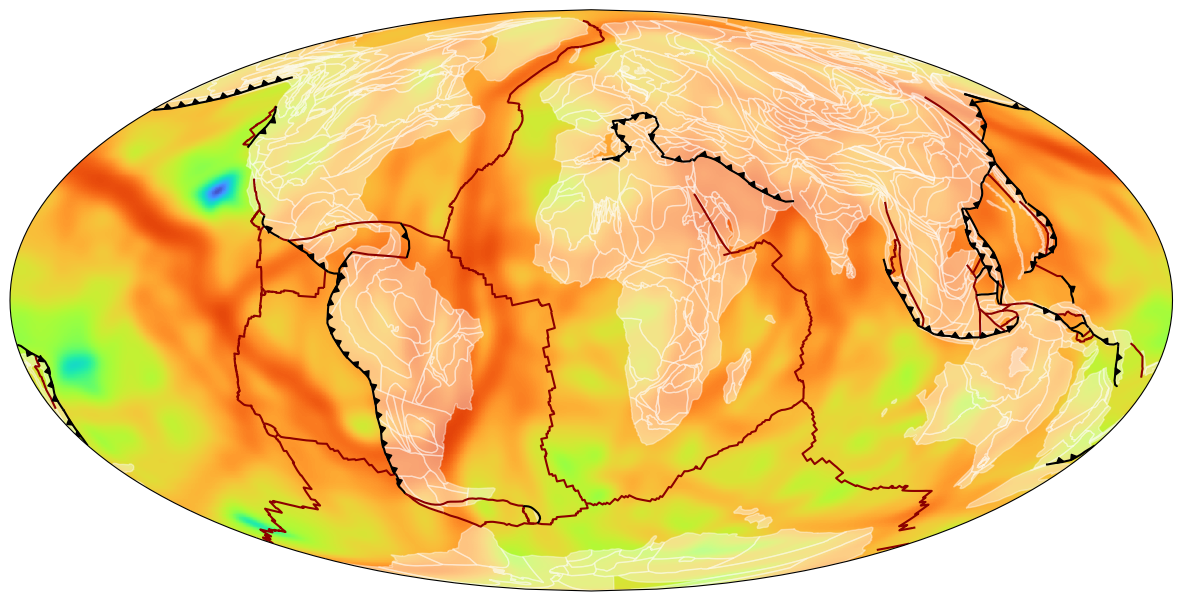

In [12]:
quantity = "mean"
reconstruction_time = 0
sample_grid = gplately.Raster(

    output_smooth_cumulative_subducted_water_filename.format(
        distance_km,
        "Mantle", 
        quantity, 
        "Mantle".lower(), 
        reconstruction_time
    )
)

import copy 

proj = ccrs.Mollweide()
fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(111, projection=proj)
ax.set_global()

ax.imshow(np.array([[0.9,0.9],[0.9,0.9]]), extent=[-180,180,-180,180], cmap='gray', vmin=0, vmax=1,
          transform=ccrs.PlateCarree(), zorder=0)

data = sample_grid.data*1e6

lognorm_cmap = copy.copy(matplotlib.cm.get_cmap('turbo'))
lognorm_cmap.set_under(color='w', alpha=0)
im = ax.imshow(data, extent=extent_globe, origin='lower', cmap=lognorm_cmap, norm=mcolors.LogNorm(vmin=1e1, vmax=1e6), 
               transform=ccrs.PlateCarree(), interpolation='nearest')

gplot.time = reconstruction_time
# add_continents(ax,  facecolor='0.7', zorder=0)
gplot.plot_continents(ax, facecolor='w', edgecolor='w', alpha=0.4, zorder=2)
gplot.plot_ridges(ax, color='DarkRed', linewidth=1.5, zorder=2)
gplot.plot_transforms(ax, color='DarkRed', linewidth=1.5, zorder=2)
# add_quiver(ax, reconstruction_time, color='k', alpha=0.33, zorder=3)
gplot.plot_trenches(ax, color='k', zorder=2)
gplot.plot_subduction_teeth(ax, color='k', zorder=2)

### Plotting a sample smoothed crustal carbon grid

/var/folders/ry/3sftjhts50x0vr1cmqhbw1z40000gp/T/ipykernel_26381/3193987506.py:27: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.


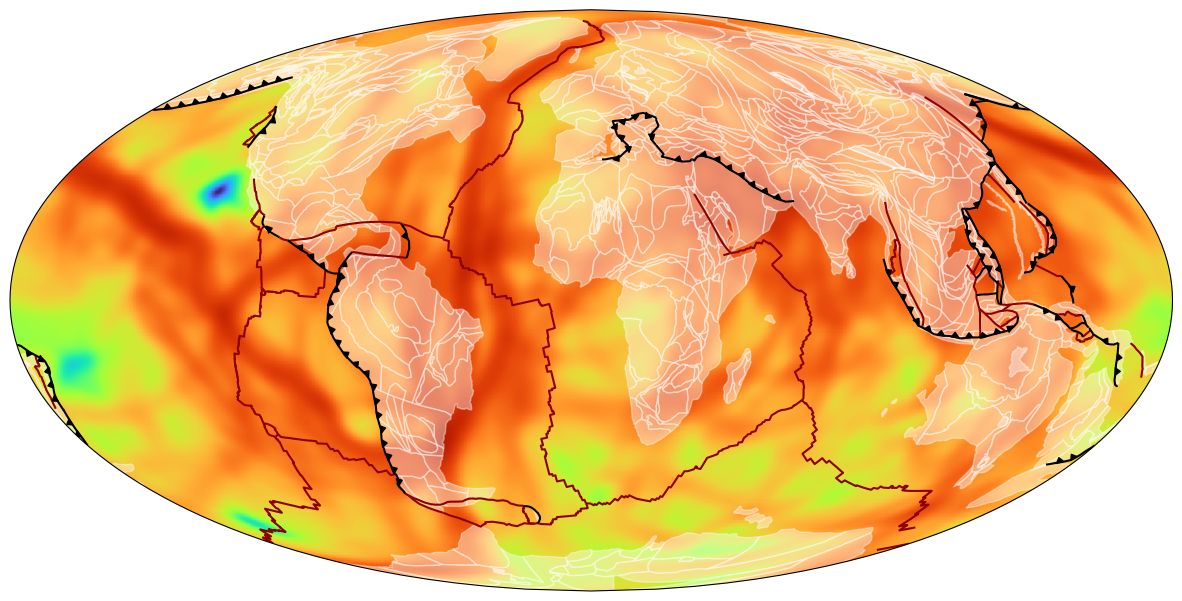

In [18]:
quantity = "mean"
reconstruction_time = 0
sample_grid = gplately.Raster(

    output_smooth_cumulative_subducted_water_filename.format(
        500,
        "Crust", 
        quantity, 
        "Crust".lower(), 
        reconstruction_time
    )
    
)

import copy 

proj = ccrs.Mollweide()
fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(111, projection=proj)
ax.set_global()

ax.imshow(np.array([[0.9,0.9],[0.9,0.9]]), extent=[-180,180,-180,180], cmap='gray', vmin=0, vmax=1,
          transform=ccrs.PlateCarree(), zorder=0)

data = sample_grid.data*1e6

lognorm_cmap = copy.copy(matplotlib.cm.get_cmap('turbo'))
lognorm_cmap.set_under(color='w', alpha=0)
im = ax.imshow(data, extent=extent_globe, origin='lower', cmap=lognorm_cmap, norm=mcolors.LogNorm(vmin=1e1, vmax=1e5), 
               transform=ccrs.PlateCarree(), interpolation='nearest')

gplot.time = reconstruction_time
# add_continents(ax,  facecolor='0.7', zorder=0)
gplot.plot_continents(ax, facecolor='w', edgecolor='w', alpha=0.4, zorder=2)
gplot.plot_ridges(ax, color='DarkRed', linewidth=1.5, zorder=2)
gplot.plot_transforms(ax, color='DarkRed', linewidth=1.5, zorder=2)
# add_quiver(ax, reconstruction_time, color='k', alpha=0.33, zorder=3)
gplot.plot_trenches(ax, color='k', zorder=2)
gplot.plot_subduction_teeth(ax, color='k', zorder=2)